*Import các thư viện cần thiết trong quá trình thu thập dữ liệu*

In [2]:
from selenium import webdriver
from time import sleep
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from facebook_scraper import get_posts
import pandas as pd
import csv
import facebook_scraper as fs

c:\Users\huyho\AppData\Local\Programs\Python\Python311\Lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


*Khai báo email, mật khẩu tài khoản facebook để crawl và ID của trang sắp được crawl*

In [1]:
EMAIL = "0337712718"
PASSWORD = "HoangUET2004@"
PAGE_ID = "Theanh28"

### Xác định một số hàm chức năng mà chúng ta sẽ sử dụng trong quá trình thu thập thông tin

In [1]:
def initDriver():
    '''
    Khởi tạo trình điều khiển chrome với các tùy chọn tắt thông báo
    Về cơ bản tạo một cửa sổ trình duyệt
    '''
    options = webdriver.ChromeOptions()
    options.add_argument("--disable-notifications")
    return webdriver.Chrome(options=options)

In [ ]:
def fbLogin(driver, email, password):
    '''
    Đăng nhập facebook sau khi mở trình duyệt
    sử dụng email và mật khẩu đã cho
    '''
    driver.get("https://facebook.com")

    # Login
    userEmail = driver.find_element(by="id", value="email")
    userEmail.send_keys(email)
    userPass = driver.find_element(by="id", value="pass")
    userPass.send_keys(password)

    userPass.send_keys(Keys.ENTER)

In [2]:
def readData(fileName):
    ''' 
    Đọc dữ liệu từ file đã cho
    Chủ yếu được sử dụng để đọc danh sách ID bài đăng
    '''
    f = open(fileName, 'r', encoding='utf-8')
    data = []
    for i, line in enumerate(f):
        try:
            line = repr(line)
            line = line[1:len(line) - 3]
            data.append(line)
        except:
            print("Error writing line")
    return data

In [3]:
def writeFileTxt(fileName, content):
    ''' 
    Viết vào tập tin
    Chủ yếu được sử dụng để lưu danh sách ID bài đăng
    '''
    with open(fileName, 'a') as f1:
        f1.write(content + '\n')

In [ ]:
def getPostID(driver, filePath= 'Data/data_post_id.csv'):
    ''' 
    Nhận tất cả ID bài đăng trên trang trình duyệt vào lúc này
    cũng kéo xuống để tải thêm bài viết
    '''
    allPost = readData(filePath) # List of posts ID
    sleep(5)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    elements = driver.find_elements(By.XPATH, '//a[contains(@href, "https://www.facebook.com/Theanh28/posts/") and contains(@class, "x1i10hfl xjbqb8w x6umtig x1b1mbwd xaqea5y xav7gou x9f619 x1ypdohk xt0psk2 xe8uvvx xdj266r x11i5rnm xat24cr x1mh8g0r xexx8yu x4uap5 x18d9i69 xkhd6sd x16tdsg8 x1hl2dhg xggy1nq x1a2a7pz xt0b8zv xi81zsa xo1l8bm")]')
    if len(elements):
        for element in elements:
            postId = element.get_attribute("href").split('posts/')[1].split('?')[0]
            if postId not in allPost:
                print(postId)
                writeFileTxt(filePath, postId)

In [ ]:
def getnumPost(driver, page_id, amount, filePath= 'Data/data_post_id.csv'):
    ''' 
    Sử dụng hàm getPostID để lấy ID bài đăng
    cho đến khi đạt đủ số lượng bài viết cần thiết
    '''
    driver.get("https://facebook.com/" + page_id)
    while len(readData(filePath)) < amount:
        getPostID(driver, filePath)

**Lấy dữ liệu các bài viết trong vòng 30 ngày**


*Vì đây là trang lớn nên có nhiều bài viết. Tôi sẽ lấy các bài từ ngày 1/10/2023 đến ngày 31/10/2023, ước tính số lượng bài đăng dưới 2000. Đặt bộ lọc trên Facebook trỏ đến ngày 31/10/2023 để thu thập dữ liệu từ đó*

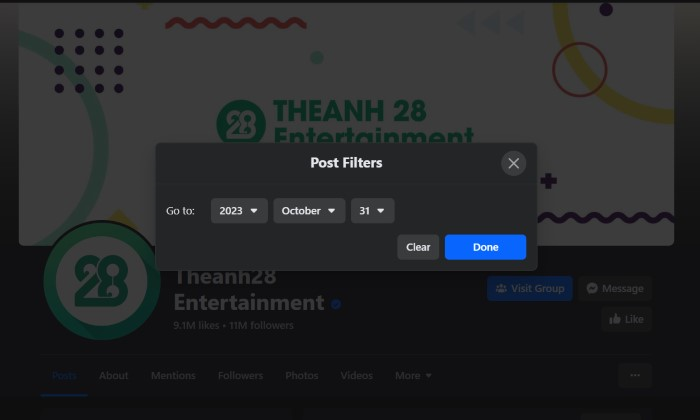

**Để tránh lỗi dữ liệu, tôi sẽ crawl nhiều lần rồi xử lý dữ liệu dư thừa và sắp xếp lại sau**

In [ ]:
driver = initDriver() # Browser 
fbLogin(driver, EMAIL, PASSWORD) # Login to facebook
sleep(25) # Wait for the page to load
getnumPost(driver, PAGE_ID, 2000) # Get 2000 post IDs and save to Data/data_post_id_1.csv

In [ ]:
driver.quit()

In [ ]:
import pandas as pd

# Đọc dữ liệu từ tệp CSV
df = pd.read_csv('Data/data_post_id.csv')

# Xóa các dòng trùng lặp
df = df.drop_duplicates()

# Lưu lại dữ liệu đã được xử lý
df.to_csv('Data/data_post_id.csv', index=False)


**Lấy dữ liệu từ các bài viết qua post_id bằng hàm get_posts**

In [7]:
post_IDs = readData('Data/data_post_id.csv') # Chuyển Data/data_post_id.csv thành danh sách post_IDs
print(len(post_IDs))

1651


In [ ]:
# Lấy dữ liệu
options = {
    "reactions" : True,
    "allow_extra_requests": True,
    "reactors":False,
    "progress":True,
    "shares":False
}
# Try to get as many post as possible for one account
for post in get_posts(
    post_urls= [f"https://facebook.com/{id}" for id in post_IDs], 
    options=options,
    credentials=(EMAIL,PASSWORD)
):
    print(post)
    df = pd.concat([df,pd.DataFrame([post])],ignore_index=True)

In [ ]:
df.to_csv('Data/chuaxuly.csv', index=False) #chuyển dataframe thành định dạng csv

In [3]:
df = pd.read_csv('Data/chuaxuly.csv')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [8]:
df

,original_request_url,post_url,post_id,text,post_text,shared_text,original_text,time,timestamp,image,image_lowquality,images,images_description,images_lowquality,images_lowquality_description,video,video_duration_seconds,video_height,video_id,video_quality,video_size_MB,video_thumbnail,video_watches,video_width,likes,comments,shares,link,links,user_id,username,user_url,is_live,factcheck,shared_post_id,shared_time,shared_user_id,shared_username,shared_post_url,available,comments_full,reactors,w3_fb_url,reactions,reaction_count,with,page_id,sharers,image_id,image_ids,was_live,fetched_time,video_ids,videos,header
0,https://facebook.com/pfbid02q7ndMTwaLyHQRJTVvM...,https://facebook.com/story.php?story_fbid=pfbi...,pfbid0ma9SSJKDVeDfgqMqkFWe5USuAzQXdiPXTr6aUcAB...,31/10 THẾ GIỚI CÓ GÌ?\n\n10/31 WHATS GOING ON ...,31/10 THẾ GIỚI CÓ GÌ?\n\n10/31 WHATS GOING ON ...,NaN,31/10 THẾ GIỚI CÓ GÌ?,2023-11-01 06:05:33,1.698794e+09,NaN,https://scontent.fsgn2-5.fna.fbcdn.net/v/t15.5...,[],[],['https://scontent.fsgn2-5.fna.fbcdn.net/v/t15...,[None],https://scontent.fsgn2-10.fna.fbcdn.net/v/t42....,NaN,NaN,2.015716e+15,NaN,NaN,https://scontent.fsgn2-5.fna.fbcdn.net/v/t15.5...,NaN,NaN,529.0,7,3,NaN,[],100069153349307,Theanh28 Entertainment,https://facebook.com/Theanh28?eav=Afa5sb8seWw6...,False,NaN,NaN,NaN,NaN,NaN,NaN,True,"[{'comment_id': '874923734066185', 'comment_ur...",[],https://www.facebook.com/story.php?story_fbid=...,"{'like': 529, 'love': 55, 'haha': 1}",585,NaN,1509435412435707,NaN,NaN,[],False,2023-11-10 13:52:27.102811,NaN,NaN,NaN
1,https://facebook.com/pfbid035qUxjihqQecnxDP2m9...,https://facebook.com/story.php?story_fbid=pfbi...,pfbid035qUxjihqQecnxDP2m9EC5cTDKE6YLK3PkNVYt2N...,Vụ nhiều nhất là lấy được 100 triệu 😳,Vụ nhiều nhất là lấy được 100 triệu 😳,NaN,NaN,2023-10-31 21:38:42,1.698763e+09,NaN,https://scontent.fsgn2-3.fna.fbcdn.net/v/t15.5...,[],[],['https://scontent.fsgn2-3.fna.fbcdn.net/v/t15...,[None],https://scontent.fsgn2-6.fna.fbcdn.net/v/t42.1...,NaN,NaN,2.992613e+14,NaN,NaN,https://scontent.fsgn2-3.fna.fbcdn.net/v/t15.5...,NaN,NaN,2043.0,325,18,NaN,[],100069153349307,Theanh28 Entertainment,https://facebook.com/Theanh28?eav=AfbQKKJeOUPP...,False,NaN,NaN,NaN,NaN,NaN,NaN,True,"[{'comment_id': '346436441388284', 'comment_ur...",[],https://www.facebook.com/story.php?story_fbid=...,"{'like': 2043, 'love': 13, 'haha': 836, 'wow':...",2938,NaN,1509435412435707,NaN,NaN,[],False,2023-11-10 14:48:48.832069,NaN,NaN,NaN
2,https://facebook.com/pfbid02qUKRtLC73DJ6p6BWRP...,https://facebook.com/story.php?story_fbid=pfbi...,pfbid0mSiiQWzYNNAydQEzZ7R959Y4E4p9mgMFgDdxokNT...,Đừng nói đàn ông sẽ thay lòng đổi dạ khi chạm ...,Đừng nói đàn ông sẽ thay lòng đổi dạ khi chạm ...,NaN,Đừng nói đàn ông sẽ thay lòng đổi dạ khi chạm ...,2023-10-31 22:11:18,1.698765e+09,https://scontent.fsgn2-6.fna.fbcdn.net/v/t39.3...,https://scontent.fsgn2-6.fna.fbcdn.net/v/t39.3...,['https://scontent.fsgn2-6.fna.fbcdn.net/v/t39...,['May be an image of 4 people and text that sa...,['https://scontent.fsgn2-6.fna.fbcdn.net/v/t39...,['May be an image of 4 people and text that sa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24843.0,1084,286,NaN,[{'link': 'https://m.facebook.com/photo.php?fb...,100069153349307,Theanh28 Entertainment,https://facebook.com/Theanh28?eav=AfYzVxIogkeW...,False,NaN,NaN,NaN,NaN,NaN,NaN,True,"[{'comment_id': '2259478780924921', 'comment_u...",[],https://www.facebook.com/story.php?story_fbid=...,"{'like': 24843, 'love': 8311, 'haha': 71, 'wow...",36631,NaN,1509435412435707,NaN,6.446441e+14,['644644134517359'],False,2023-11-10 14:56:06.257377,NaN,NaN,NaN
3,https://facebook.com/pfbid0rQbacHCFsWbN12fpcxu...,https://facebook.com/story.php?story_fbid=pfbi...,pfbid02vG3Hnx85ipDL8dTwqc143y4r4eYQaDMgfYKVHPp...,Anh trai chắc mới lĩnh lương lúc chiều 😀\nCre:...,Anh trai chắc mới lĩnh lương lúc chiều 😀\nCre:...,NaN,NaN,2023-10-31 21:43:52,1.698763e+09,NaN,https://scontent.fsgn2-7.fna.fbcdn.net/v/t15.5...,[],[],['https://scontent.fsgn2-7.fna.fbcdn.net/v/t15...,[None

In [6]:
print(len(df))

1651
